# Quantizing VS clipping

In [41]:
sequence = "bus"

In [2]:
!../sequences/$sequence/runme.sh

bus_cif.y4m exists.
ffmpeg version n4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10.2.0 (GCC)
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librav1e --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxcb --enable-libxml2 --enable-libxvid --enable-nvdec --

## Quantizing

In [53]:
!sed -z -i 's!out = clip(YUV.to_RGB(E_k) + 128)\n!#out = clip(YUV.to_RGB(E_k) + 128)\n!g' image_IPP_adaptive.py
!sed -z -i 's!#out = YUV.to_RGB(E_k)//2 + 128\n!out = YUV.to_RGB(E_k)//2 + 128\n!g' image_IPP_adaptive.py
!sed -z -i 's!dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)*1!#dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)*1!g' image_IPP_adaptive.py
!sed -z -i 's!#dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)*2!dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)*2!g' image_IPP_adaptive.py

In [54]:
!cat -n image_IPP_adaptive.py | grep "out =" 
!cat -n image_IPP_adaptive.py | grep "dq_E_k = YUV" 

   133	    #out = clip(YUV.to_RGB(E_k) + 128)
   135	    out = YUV.to_RGB(E_k)//2 + 128
   106	    dq_E_k = YUV.from_RGB(L.read(prefix + "_from_mp4", k))
   141	    #dq_E_k = YUV.from_RGB(frame.read(prefix, k))
   143	    dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)*1
   145	    #dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)*2
   146	    #dq_E_k = YUV.from_RGB(frame.read(prefix, k))
   154	    dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)


In [55]:
!python RD_curve.py 1> >(tee /tmp/output >&1) | grep BPP | grep Average | cat -n

     1	Q_step: 21 BPP: 0.2972678170594837 KBPS: 2712.2239999999997 Average AMSE: 485.13721119616304
     2	Q_step: 24 BPP: 0.21600817199775532 KBPS: 1970.824 Average AMSE: 516.746968929749
     3	Q_step: 27 BPP: 0.1541280864197531 KBPS: 1406.24 Average AMSE: 565.5530499219627
     4	Q_step: 30 BPP: 0.10939516694725028 KBPS: 998.1039999999999 Average AMSE: 636.5076678240741
     5	Q_step: 33 BPP: 0.07853535353535353 KBPS: 716.5440000000001 Average AMSE: 738.9352844854799
     6	Q_step: 36 BPP: 0.05814130892255893 KBPS: 530.472 Average AMSE: 860.8179885881383
     7	Q_step: 39 BPP: 0.0458271955667789 KBPS: 418.12 Average AMSE: 995.3113236312784


In [56]:
!grep BPP /tmp/output | grep Average | cut -d ' ' -f 4,9 | tr ' ' '\t'  > /tmp/curve_quantizing.txt

In [57]:
!cat /tmp/curve_quantizing.txt

0.2972678170594837	485.13721119616304
0.21600817199775532	516.746968929749
0.1541280864197531	565.5530499219627
0.10939516694725028	636.5076678240741
0.07853535353535353	738.9352844854799
0.05814130892255893	860.8179885881383
0.0458271955667789	995.3113236312784


In [58]:
RD_points_quantizing = []
with open("/tmp/curve_quantizing.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RD_points_quantizing.append((float(rate), float(_distortion)))

## Clipping

In [59]:
!sed -z -i 's!#out = clip(YUV.to_RGB(E_k) + 128)\n!out = clip(YUV.to_RGB(E_k) + 128)\n!g' image_IPP_adaptive.py
!sed -z -i 's!out = YUV.to_RGB(E_k)//2 + 128\n!#out = YUV.to_RGB(E_k)//2 + 128\n!g' image_IPP_adaptive.py
!sed -z -i 's!#dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)*1!dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)*1!g' image_IPP_adaptive.py
!sed -z -i 's!dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)*2!#dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)*2!g' image_IPP_adaptive.py

In [61]:
!cat -n image_IPP_adaptive.py | grep "out =" 
!cat -n image_IPP_adaptive.py | grep "dq_E_k = YUV" 

   133	    out = clip(YUV.to_RGB(E_k) + 128)
   135	    #out = YUV.to_RGB(E_k)//2 + 128
   106	    dq_E_k = YUV.from_RGB(L.read(prefix + "_from_mp4", k))
   141	    #dq_E_k = YUV.from_RGB(frame.read(prefix, k))
   143	    dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)*1
   145	    #dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)*2
   146	    #dq_E_k = YUV.from_RGB(frame.read(prefix, k))
   154	    dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)


In [62]:
!python RD_curve.py 1> >(tee /tmp/output >&1) | grep BPP | grep Average | cat -n

     1	Q_step: 21 BPP: 0.438279496352413 KBPS: 3998.7920000000004 Average AMSE: 40.97219153338946
     2	Q_step: 24 BPP: 0.3275550645342312 KBPS: 2988.56 Average AMSE: 63.58114324670316
     3	Q_step: 27 BPP: 0.23963155864197533 KBPS: 2186.3599999999997 Average AMSE: 99.81794540456649
     4	Q_step: 30 BPP: 0.17150059624017958 KBPS: 1564.7440000000001 Average AMSE: 156.88415425960997
     5	Q_step: 33 BPP: 0.12153303872053872 KBPS: 1108.8480000000002 Average AMSE: 239.72344352816359
     6	Q_step: 36 BPP: 0.08728079405162739 KBPS: 796.3359999999999 Average AMSE: 350.3104936079545
     7	Q_step: 39 BPP: 0.06542683782267115 KBPS: 596.9440000000001 Average AMSE: 496.22877867213805


In [66]:
!grep BPP /tmp/output | grep Average | cut -d ' ' -f 4,9 | tr ' ' '\t'  > /tmp/curve_clipping.txt

In [67]:
!cat /tmp/curve_clipping.txt

0.438279496352413	40.97219153338946
0.3275550645342312	63.58114324670316
0.23963155864197533	99.81794540456649
0.17150059624017958	156.88415425960997
0.12153303872053872	239.72344352816359
0.08728079405162739	350.3104936079545
0.06542683782267115	496.22877867213805


In [68]:
RD_points_clipping = []
with open("/tmp/curve_clipping.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RD_points_clipping.append((float(rate), float(_distortion)))

## Comparison

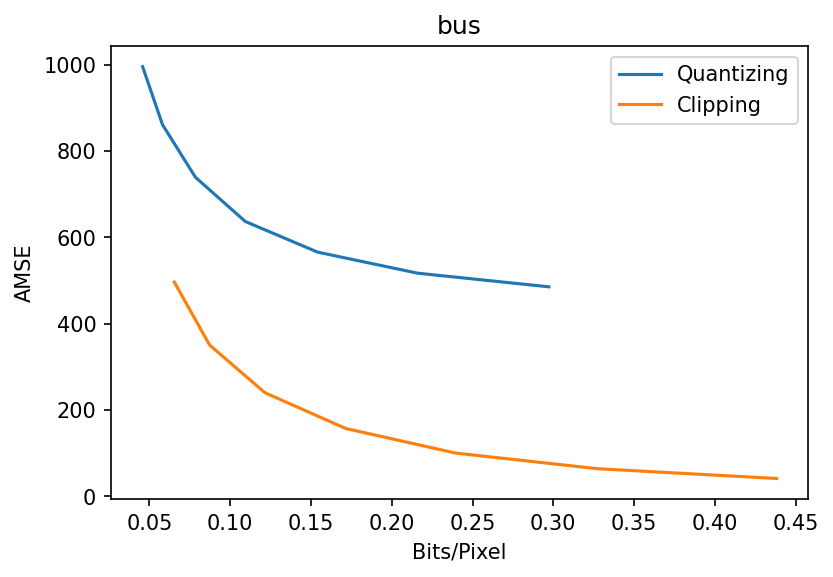

In [69]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import pylab

pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points_quantizing), label="Quantizing")
pylab.plot(*zip(*RD_points_clipping), label="Clipping")
pylab.title(f"{sequence}")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("AMSE")
plt.legend(loc='upper right')
pylab.show()

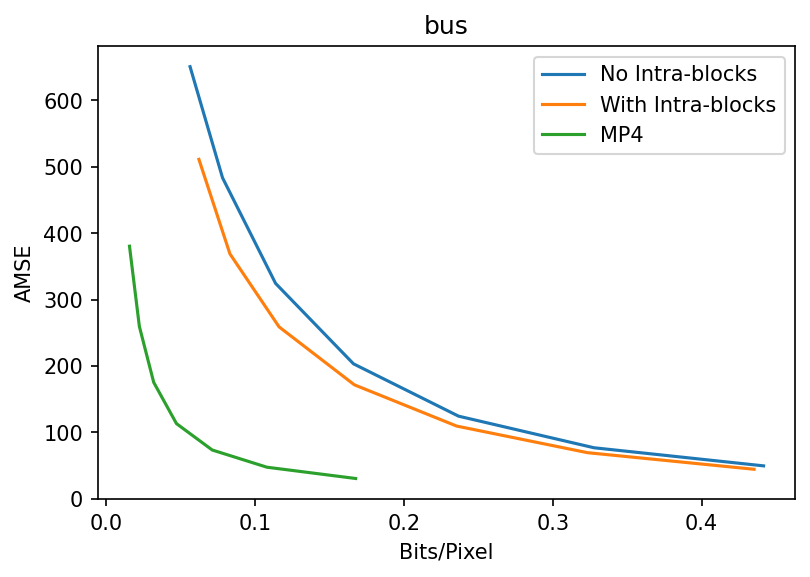

In [23]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import pylab

pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points_no_intrablocks), label="No Intra-blocks")
pylab.plot(*zip(*RD_points_with_intrablocks), label="With Intra-blocks")
pylab.plot(*zip(*RD_points_MP4), label="MP4")
pylab.title(f"{sequence}")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("AMSE")
plt.legend(loc='upper right')
pylab.show()